In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gp
sns.set_theme()

from elasticsearch import Elasticsearch, helpers
import json
es = Elasticsearch(['https://3d6a9dd50c7c49c9ab5d23b6891bc03e.us-central1.gcp.cloud.es.io:9243'], 
                    http_auth=('elastic', 'WMzYk5RXyzE7MRShwPVwHzPX'), timeout=30)

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
    
# To stop cell timing, use:
# %unload_ext autotime

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


time: 249 µs (started: 2021-12-08 16:19:23 -05:00)


In [2]:
STATE_FIPS_DICT_52 = { '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', 
                      '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', 
                      '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', 
                      '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', 
                      '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', 
                      '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', 
                      '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', 
                      '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', 
                      '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', 
                      '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', 
                      '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', 
                      '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', 
                      '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'}
STATE_LIST_52 = list(sorted(STATE_FIPS_DICT_52.keys()))

STATE_FIPS_LENGTH = 2
COUNTY_FIPS_LENGTH = 5
TRACT_FIPS_LENGTH = 11
BLOCKGROUP_FIPS_LENGTH = 12
CENSUSBLOCK_FIPS_LENGTH = 15

bossdata_columns = [
'GEOID',
'GEOID_cbg',
# 'statefips',
'speedSourceNtia',
'speedCatNtia',
'numISPfiber',
'numISPother',
'numISPwireless',  
'num_household',
'MaxConsumerDown98',
'MaxConsumerUp98',
]

ookla_mlab_columns = [
'GEOID_cbg',
'maxDownloadMbpsMlab',
'maxDownloadMbpsOokla',
'maxUploadMbpsMlab',
'maxUploadMbpsOokla',
'meanDownloadMbpsMlab',
'meanDownloadMbpsOokla',
'meanUploadMbpsMlab',
'meanUploadMbpsOokla',
'medDownloadMbpsMlab',
'medDownloadMbpsOokla',
'medUploadMbpsMlab',
'medUploadMbpsOokla',
'minDownloadMbpsMlab',
'minDownloadMbpsOokla',
'minUploadMbpsMlab',
'minUploadMbpsOokla',
'numDeviceDownloadMlab',
'numDeviceOokla',
'numDeviceUploadMlab',
'numTestDownloadMlab',
'numTestOokla',
'numTestUploadMlab',
'speedCatMlab',
'speedCatOokla',
'speedSourceMlab',
'speedSourceOokla',
]

In [263]:
ookla = pd.read_csv('MLAB/blockgroup_ookla.csv')
ookla['GEOID_cbg'] = ookla['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)

mlab_t = pd.read_csv('MLAB/blockgroup_mlab_training.csv')
mlab_t['GEOID_cbg'] = mlab_t['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)
mlab_p = pd.read_csv('MLAB/blockgroup_mlab_pred.csv')
mlab_p['GEOID_cbg'] = mlab_p['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)
mlab = pd.concat([mlab_t, mlab_p])

ntia = pd.read_csv('MLAB/blockgroup_ntia_all.csv')
ntia['GEOID_cbg'] = ntia['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)
ntia = ntia.fillna(value=0)


GEOID_cbg            0
MaxConsumerDown98    0
MaxConsumerUp98      0
numISPfiber          0
numISPother          0
numISPwireless       0
num_household        0
speedCatNtia         0
speedSourceNtia      0
dtype: int64

In [264]:
print(mlab.shape, ookla.shape, ntia.shape)

(217860, 18) (217860, 16) (220333, 9)


In [265]:
mlab = mlab.drop(columns=['lat', 'lng', 'statefips'], errors="ignore")
ookla = ookla.drop(columns=['lat', 'lng', 'statefips'], errors="ignore")
ntia = ntia.drop(columns=['lat', 'lng', 'statefips'], errors="ignore")

all_speed = mlab.merge(ookla, on='GEOID_cbg')
all_speed = all_speed.merge(ntia, on='GEOID_cbg', how='outer')
all_speed['statefips'] = all_speed['GEOID_cbg'].str[:STATE_FIPS_LENGTH]
all_speed.loc[all_speed['speedCatOokla'].isnull(), ['speedCatOokla', 'speedCatMlab']] = all_speed['speedCatNtia']
all_speed.loc[all_speed['speedSourceOokla'].isnull(), ['speedSourceOokla', 'speedSourceMlab']] = 'fromSpeedCatNtia'
all_speed.isnull().sum()

GEOID_cbg                   0
maxDownloadMbpsMlab      2473
maxUploadMbpsMlab        2473
meanDownloadMbpsMlab     2473
meanUploadMbpsMlab       2473
medDownloadMbpsMlab      2473
medUploadMbpsMlab        2473
minDownloadMbpsMlab      2473
minUploadMbpsMlab        2473
numDeviceDownloadMlab    2473
numDeviceUploadMlab      2473
numTestDownloadMlab      2473
numTestUploadMlab        2473
speedCatMlab                0
speedSourceMlab             0
maxDownloadMbpsOokla     2473
maxUploadMbpsOokla       2473
meanDownloadMbpsOokla    2473
meanUploadMbpsOokla      2473
medDownloadMbpsOokla     2473
medUploadMbpsOokla       2473
minDownloadMbpsOokla     2473
minUploadMbpsOokla       2473
numDeviceOokla           2473
numTestOokla             2473
speedCatOokla               0
speedSourceOokla            0
MaxConsumerDown98           0
MaxConsumerUp98             0
numISPfiber                 0
numISPother                 0
numISPwireless              0
num_household               0
speedCatNt

In [268]:
# Export to csv 
all_speed.to_csv('all_speed.csv', index=False)

In [114]:
# Import all_speed from csv
all_speed = pd.read_csv('all_speed.csv')

In [158]:
def create_speed_index(es, ES_ROW_GEOID, index_name):
    create_request_body = {
       "settings": {
        "refresh_interval": "1s",
        "number_of_shards": 1,
        "number_of_replicas": 0
      },
        "mappings":{ 
            "properties":{
                ES_ROW_GEOID            : { "type":"text"},
                "statefips"             : { "type": "text" },
                
                "speedCatMlab"          : { "type": "integer" },
                'numTestDownloadMlab'   : { "type": "integer"},
                'numDeviceDownloadMlab' : { "type": "integer"},
                'numTestUploadMlab'     : { "type": "integer"},
                'numDeviceUploadMlab'   : { "type": "integer"},
                "meanUploadMbpsMlab"    : { "type": "float" },
                "meanDownloadMbpsMlab"  : { "type": "float" },
                "medUploadMbpsMlab"     : { "type": "float" },
                "medDownloadMbpsMlab"   : { "type": "float" },
                "minUploadMbpsMlab"     : { "type": "float" },
                "minDownloadMbpsMlab"   : { "type": "float" },
                "maxUploadMbpsMlab"     : { "type": "float" },
                "maxDownloadMbpsMlab"   : { "type": "float" },
                "speedSourceMlab"  : { "type": "text" },
                
                "speedCatOokla"          : { "type": "integer" },
                'numTestOokla'           : { "type": "integer"},
                'numDeviceOokla'         : { "type": "integer"},
                "meanUploadMbpsOokla"    : { "type": "float" },
                "meanDownloadMbpsOokla"  : { "type": "float" },
                "medUploadMbpsOokla"     : { "type": "float" },
                "medDownloadMbpsOokla"   : { "type": "float" },
                "minUploadMbpsOokla"     : { "type": "float" },
                "minDownloadMbpsOokla"   : { "type": "float" },
                "maxUploadMbpsOokla"     : { "type": "float" },
                "maxDownloadMbpsOokla"   : { "type": "float" },
                "speedSourceOokla"  : { "type": "text" },
                
                "speedCatNtia"          : { "type": "integer" },
                'num_household'   : { "type": "integer"},
                "numISPwireless"   : { "type": "integer" },
                "numISPother"     : { "type": "integer" },
                "numISPfiber"   : { "type": "integer" },
                "MaxConsumerUp98"     : { "type": "float" },
                "MaxConsumerDown98"   : { "type": "float" },
                "speedSoureNtia"  : { "type": "text" },
            }
        }
    } 

    es.indices.create(index = index_name, body = create_request_body)
    print('created index ', index_name)

def upload_df(es, df, index_name, id_column, op_type):
    # """ This function upload plain json file, not geojson"""
    df = df.to_json(orient = 'records')
    json_records = json.loads(df)
    action_list = []
    for row in json_records:
        record = {
            '_op_type': op_type,
            '_index': index_name,
            # The type of the document
            "_type": '_doc', 
            '_id':row[id_column],
        }
        if op_type == 'update':
            record['doc_as_upsert'] = True
            record['doc'] = row
            # "doc": {"newkey": 'newvalue'},
        elif op_type == 'index':
            # a comma-separated list of the fields you want to retrieve.'
            record['_source'] = row
        else:
            print('upload_df only accepts `update` or `index`')
                   
        action_list.append(record)
        
    # bulk UPLOAD the records
    helpers.bulk(es, action_list)
    print(f"finished uploading {len(json_records)} records to {index_name}")
    

In [279]:
index_name = "speed_cbg_all"
ES_ROW_GEOID = 'GEOID_cbg'

# RUN ONCE
# create_speed_index(es, ES_ROW_GEOID, index_name)

# RUN ONCE: LONG TIME
# upload_df(es, all_speed, index_name, ES_ROW_GEOID, 'index')


finished uploading 220333 records to speed_cbg_all


# CENSUS BLOCK speeds

In [48]:
# Import CBG speeds
speed_cbg_all = pd.read_csv('speed_cbg_all.csv')
speed_cbg_all['GEOID_cbg'] = speed_cbg_all['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)
speed_cbg_all['statefips'] = speed_cbg_all['GEOID_cbg'].str[:STATE_FIPS_LENGTH]
    

In [35]:
# IMPORT ookla speeds
ookla_cb_all = []
ookla_cb = {}
census_level = 'cb'

for statefips in STATE_LIST_52:
    filename = f"Ookla/db/ookla-2021q3-{statefips}-{census_level}.csv"
    ookla_cb[statefips] = pd.read_csv(filename)
    ookla_cb_all.append(ookla_cb[statefips])
        
print("COMPLETED IMPORTING")

ookla_cb_all = pd.concat(ookla_cb_all, ignore_index=True)
ookla_cb_all['GEOID'] = ookla_cb_all['GEOID'].astype(str).str.zfill(CENSUSBLOCK_FIPS_LENGTH)
ookla_cb_all['statefips'] = ookla_cb_all['GEOID'].str[:STATE_FIPS_LENGTH]
ookla_cb_all['GEOID_cbg'] = ookla_cb_all['GEOID'].str[:BLOCKGROUP_FIPS_LENGTH]

ookla_cb_all['speedSourceOokla'] = 'ooklaTiles'

ookla_cb_all.shape # (6,525,270 / 15)

COMPLETED IMPORTING


(6525270, 15)

In [71]:
# Opportunity zones (Census tracts)
oz_tract = pd.read_csv('OpportunityZones/n-18-48-complete-renamed.csv')
oz_tract['GEOID_ct'] = oz_tract['GEOID_ct'].astype(str).str.zfill(TRACT_FIPS_LENGTH)
oz_tract['statefips'] = oz_tract['statefips'].astype(str).str.zfill(STATE_FIPS_LENGTH)
oz_tract = oz_tract.loc[:, ['GEOID_ct', 'tractTypeOZ']]

In [30]:
def add_speed_category_column_ntia(ntia_df):
    def helper(row):
        if row['num_household'] == 0:
            return 0
        if row['MaxConsumerDown98'] < 25 or row['MaxConsumerUp98'] < 3:
            return 0 
        if  (row['numISPfiber'] and row['numISPfiber'] < 1 and
            row['numISPother'] and row['numISPother'] < 1 and
            row['numISPwireless'] and row['numISPwireless'] < 1 ):
            return 0
        
        if row['MaxConsumerDown98'] < 100 or row['MaxConsumerUp98'] < 20:
            return 1 # underserved
        
        return 2
    ntia_df['speedCatNtia'] = ntia_df.apply(helper, axis = 1)

In [120]:
# The orders matter: it affects the correctness of the logics
def add_speedRankReady_cb(state_cb_df):
    # red
    state_cb_df['speedRankReady'] = 'Underserved'

    # yellow
    state_cb_df.loc[
        (
    #         (state_cb_df['speedCatNtia'] != 0) & 
            (state_cb_df['speedCatMlab'] == 0) | (state_cb_df['speedCatOokla'] == 0) 
        ), 
             ['speedRankReady']]= 'UnservedArguably'

    # orange
    state_cb_df.loc[
        (
    #         (state_cb_df['speedCatNtia'] != 0) & 
              (state_cb_df['speedCatMlab'] == 0) & (state_cb_df['speedCatOokla'] == 0)
        ), 
             ['speedRankReady']]= 'UnservedLikely'

    # FINALLY:
    # green
    state_cb_df.loc[
        (
              (state_cb_df['speedCatNtia'] == 2) & 
              (state_cb_df['speedCatMlab'] != 0) & (state_cb_df['speedCatOokla'] != 0)
        ), 
             ['speedRankReady']]= 'Served'

    # red
    state_cb_df.loc[state_cb_df['speedCatNtia'] == 0, ['speedRankReady']]= 'UnservedDef'
    
#     print('speedRankReady value_counts :\n', state_cb_df['speedRankReady'].value_counts())
#     print("speedRankReady should have 0 null values: ", state_cb_df['speedRankReady'].isnull().sum())


## Download ES bossdata

In [12]:
# elasticsearch-py scan https://elasticsearch-py.readthedocs.io/en/master/helpers.html#scan
def get_all_ES_records(index_name):
    print('Querying/Downloading index ', index_name)
    match_all_query = {"query": {"match_all": {}}}
    res_gen = helpers.scan(es, query= match_all_query, index= index_name)
    df = pd.DataFrame([record['_source'] for record in res_gen])
    df['speedSourceNtia'] = 'maxConsumerFCC'        
    return df[bossdata_columns]


In [14]:
STATE_DICT_REM = { 
#     '01': 'AL', '02': 'AK', 
#     '04': 'AZ', '05': 'AR', '06': 'CA', 
# '08': 'CO', '09': 'CT', '10': 'DE', 
# '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', 
# '16': 'ID', '17': 'IL', 
# '18': 'IN', '19': 'IA', '20': 'KS', 
# '21': 'KY', '22': 'LA', '23': 'ME', 
# '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', 
# '28': 'MS', 
# '29': 'MO', 
# '30': 'MT', '31': 'NE', 
# '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', 
# '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', 
# '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', 
# '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', 
# '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', 
# '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'
}

STATE_LIST_REM = list(sorted(STATE_DICT_REM.keys()))

# DOWNLOAD AND EXPORT TO CSV
for statefips in STATE_LIST_REM:
    index_name = f"bossdata{statefips}"
    # # just to make sure that the index exists, before updating/uploading
    if es.indices.exists(index= index_name):
        # # SUPER SLOW
        df = get_all_ES_records(index_name)
        print(index_name, df.shape)
        # Export to csv
        # df.to_csv(f"bossdata/{index_name}.csv", index=False)
        print(f"completed exporting bossdata/{index_name}.csv")


Querying/Downloading index  bossdata01
bossdata01 (252266, 10)
completed exporting bossdata/bossdata01.csv
Querying/Downloading index  bossdata02
bossdata02 (45292, 10)
completed exporting bossdata/bossdata02.csv
Querying/Downloading index  bossdata29
bossdata29 (343565, 10)
completed exporting bossdata/bossdata29.csv


In [89]:
# IMPORTANT VARIABLE to hold temp values
# BOSSDATA_DICT = {}

In [168]:
STATE_DICT_REM = { 
#     '01': 'AL',
'02': 'AK', 
'04': 'AZ', '05': 'AR', '06': 'CA', 
'08': 'CO', '09': 'CT', '10': 'DE', 
'11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', 
'16': 'ID', '17': 'IL', 
'18': 'IN', '19': 'IA', '20': 'KS', 
'21': 'KY', '22': 'LA', '23': 'ME', 
'24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', 
'28': 'MS', 
'29': 'MO', 
'30': 'MT', '31': 'NE', 
'32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', 
'36': 'NY', 
    '37': 'NC', '38': 'ND', '39': 'OH', 
'40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', 
'45': 'SC', 
    '46': 'SD', 
    '47': 'TN', '48': 'TX', 
'49': 'UT', '50': 'VT', 
    '51': 'VA', 
    '53': 'WA', 
'54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'
}

STATE_LIST_REM = list(sorted(STATE_DICT_REM.keys()))

for statefips in STATE_LIST_REM:
    # READ from csv
    index_name = f"bossdata{statefips}"
    ES_cb_state = pd.read_csv(f"bossdata/{index_name}.csv")
    ES_cb_state['GEOID'] = ES_cb_state['GEOID'].astype(str).str.zfill(CENSUSBLOCK_FIPS_LENGTH)
    ES_cb_state['GEOID_cbg'] = ES_cb_state['GEOID'].str[:BLOCKGROUP_FIPS_LENGTH]
    print("Imported from csv ", index_name, ES_cb_state.shape) 

    # add speedCatNtia
    add_speed_category_column_ntia(ES_cb_state)
    ES_nulls = ES_cb_state.isnull().sum()[['GEOID', 'GEOID_cbg', 'MaxConsumerDown98', 'MaxConsumerUp98', 'speedSourceNtia', 'speedCatNtia']].values
#     print("ES attributes null count:", ES_nulls, "sum (should be 0): ", sum(ES_nulls))

    # CBG speeds
    speed_cbg_state = speed_cbg_all.loc[speed_cbg_all['statefips'] == statefips].loc[:, ookla_mlab_columns]

    # Interpolate speed_cbg_state (blockgroup) speeds to census blocks (most mlab speeds, and some ookla speeds)
    # GOAL: fill ES_cb_state using ookla_cb_state & speed_cbg_state
    cb_state_all = ES_cb_state.join(speed_cbg_state.set_index('GEOID_cbg'), on='GEOID_cbg')
    cb_state_all['speedSourceMlab'] = 'fromSpeedMlabCBG'
    cb_state_all['speedSourceOokla'] = 'fromSpeedOoklabCBG'
#     print('speedCatMlab value counts: \n', cb_state_all['speedCatMlab'].value_counts())

    # Replace blockgroup-filled ookla speeds with existing data
    # Ookla cb speeds (~50% coverage)
    ookla_cb_state = ookla_cb_all.loc[ookla_cb_all['statefips'] == statefips]
    ookla_cb_state = ookla_cb_state.drop(columns=['statefips'])

    ookla_cb_state.set_index('GEOID', inplace=True)
    cb_state_all.set_index('GEOID', inplace=True)

    cb_state_all.update(ookla_cb_state)
    cb_state_all['GEOID'] = cb_state_all.index

#     print('speedCatOokla value counts: \n', cb_state_all['speedCatOokla'].value_counts())

    speedCat_nulls = cb_state_all.isnull().sum()[['GEOID', 'speedCatMlab', 'speedCatOokla', 'speedCatNtia', 'speedSourceMlab', 'speedSourceOokla', 'speedSourceNtia']].values
#     print("speedCat Mlab, Ookla null count:", speedCat_nulls, "sum (should be 0): ", sum(speedCat_nulls))
    
    # IMPORTANT: Not 100% ES blocks (found on bossdata) are presented in speed_cbg_state: Imputing speedCat and updating speedSource!
    blockgroup_coverage_ES_blocks = set(cb_state_all['GEOID_cbg'].values) - set(speed_cbg_state['GEOID_cbg'].values)
    print("Blockgroup coverage of ES blocks (0 is best): ", len(blockgroup_coverage_ES_blocks))
    if len(blockgroup_coverage_ES_blocks) > 0:
        # If some ES blocks are not found in speed_cbg_state: they have null speedCatOokla & speedCatMlab: copy speedCatMlab and speedCatOokla from speedCatNtia
        # And set speedSourceMlab and speedSourceOokla as well
        cb_state_all.loc[cb_state_all['speedCatOokla'].isnull(), ['speedSourceOokla']] = 'fromSpeedCatNtia'
        cb_state_all.loc[cb_state_all['speedCatOokla'].isnull(), ['speedCatOokla']] = cb_state_all['speedCatNtia']
        
        cb_state_all.loc[cb_state_all['speedCatMlab'].isnull(), ['speedSourceMlab']] = 'fromSpeedCatNtia'
        cb_state_all.loc[cb_state_all['speedCatMlab'].isnull(), ['speedCatMlab']] = cb_state_all['speedCatNtia']
        
        
    # Convert types
    cb_state_all[['speedCatNtia', 'speedCatMlab', 'speedCatOokla']] = cb_state_all[[
        'speedCatNtia', 'speedCatMlab', 'speedCatOokla']].astype(int)

    ## speedRankReady
    add_speedRankReady_cb(cb_state_all)

    # Opportunity Zones
    cb_state_all['GEOID_ct'] = cb_state_all['GEOID'].str[:TRACT_FIPS_LENGTH]
    cb_state_oz = cb_state_all.loc[:, ['GEOID', 'GEOID_ct']]
    # Quick join GEOID-GEOID_ct
    cb_state_oz = cb_state_oz.join(oz_tract.set_index('GEOID_ct'), on='GEOID_ct')

    # Double check
    x, y = len(oz_tract[oz_tract['GEOID_ct'].str[:STATE_FIPS_LENGTH] == statefips]), len(cb_state_oz[~cb_state_oz['tractTypeOZ'].isnull()].loc[:,'GEOID_ct'].unique())
    print("Num joined OZ tracts: ", x, y, x >= y) 

    # Fill remaining null census block as NotOZ
    cb_state_oz['tractTypeOZ'] = cb_state_oz['tractTypeOZ'].fillna(value='isNotOZ')
#     print('tractTypeOZ value counts: \n', index_name, cb_state_oz['tractTypeOZ'].value_counts())
    # Drop extra columns (include index columns)
    cb_state_oz = cb_state_oz.drop(columns = 'GEOID_ct')
    cb_state_oz.reset_index(drop=True, inplace=True)
    cb_state_all.reset_index(drop=True, inplace=True)
    # Merge to get final results
    cb_state_ready = cb_state_all.merge(cb_state_oz, on='GEOID')

    # save to BOSSDATA_DICT (main variable)
    BOSSDATA_DICT[statefips] = cb_state_ready
    
    # EXPORT
    cb_state_ready.to_csv(f'speed_cb/speed_cb{statefips}.csv', index=False)
    print(f"Completed exporting to csv: speed_cb{statefips}, ", cb_state_ready.shape) 
    

Imported from csv  bossdata02 (45292, 10)
Blockgroup coverage of ES blocks (0 is best):  4
Not 100% ES blocks presented in speed_cbg_state: Imputing speedCat and updating speedSource!
Num joined OZ tracts:  25 25 True
Completed exporting to csv: speed_cb02,  (45292, 39)
Imported from csv  bossdata04 (241666, 10)
Blockgroup coverage of ES blocks (0 is best):  13
Not 100% ES blocks presented in speed_cbg_state: Imputing speedCat and updating speedSource!
Num joined OZ tracts:  168 168 True
Completed exporting to csv: speed_cb04,  (241666, 39)
Imported from csv  bossdata05 (186211, 10)
Blockgroup coverage of ES blocks (0 is best):  0
Num joined OZ tracts:  85 85 True
Completed exporting to csv: speed_cb05,  (186211, 39)
Imported from csv  bossdata06 (710145, 10)
Blockgroup coverage of ES blocks (0 is best):  2
Not 100% ES blocks presented in speed_cbg_state: Imputing speedCat and updating speedSource!
Num joined OZ tracts:  879 879 True
Completed exporting to csv: speed_cb06,  (710145, 39

In [175]:
BOSSDATA_DICT['51']['speedCatMlab'].value_counts()
BOSSDATA_DICT['04']['speedCatMlab'].value_counts()

1    97628
2    85509
0    58529
Name: speedCatMlab, dtype: int64

In [176]:
BOSSDATA_DICT['51']['speedSourceMlab'].value_counts()
BOSSDATA_DICT['04']['speedSourceMlab'].value_counts()


fromSpeedMlabCBG    240549
fromSpeedCatNtia      1117
Name: speedSourceMlab, dtype: int64

In [177]:
BOSSDATA_DICT['51']['speedCatOokla'].value_counts()
BOSSDATA_DICT['04']['speedCatOokla'].value_counts()


1    106295
0     90812
2     44559
Name: speedCatOokla, dtype: int64

In [178]:
BOSSDATA_DICT['51']['speedSourceOokla'].value_counts()
BOSSDATA_DICT['04']['speedSourceOokla'].value_counts()

ooklaTiles            123449
fromSpeedOoklabCBG    117781
fromSpeedCatNtia         436
Name: speedSourceOokla, dtype: int64

# Upload to ES

In [154]:
def update_bossdata_index(es, index_name):
    update_request_body = {
        "properties":{
                'numTestOokla'           : { "type": "integer"},
                'numDeviceOokla'         : { "type": "integer"},
                "meanUploadMbpsOokla"    : { "type": "float" },
                "meanDownloadMbpsOokla"  : { "type": "float" },
                "medUploadMbpsOokla"     : { "type": "float" },
                "medDownloadMbpsOokla"   : { "type": "float" },
                "minUploadMbpsOokla"     : { "type": "float" },
                "minDownloadMbpsOokla"   : { "type": "float" },
                "maxUploadMbpsOokla"     : { "type": "float" },
                "maxDownloadMbpsOokla"   : { "type": "float" },

                'numTestDownloadMlab'   : { "type": "integer"},
                'numDeviceDownloadMlab' : { "type": "integer"},
                'numTestUploadMlab'     : { "type": "integer"},
                'numDeviceUploadMlab'   : { "type": "integer"},
                "meanUploadMbpsMlab"    : { "type": "float" },
                "meanDownloadMbpsMlab"  : { "type": "float" },
                "medUploadMbpsMlab"     : { "type": "float" },
                "medDownloadMbpsMlab"   : { "type": "float" },
                "minUploadMbpsMlab"     : { "type": "float" },
                "minDownloadMbpsMlab"   : { "type": "float" },
                "maxUploadMbpsMlab"     : { "type": "float" },
                "maxDownloadMbpsMlab"   : { "type": "float" },
            
                "speedSourceNtia"        : { "type": "text" },
                "speedSourceMlab"        : { "type": "text" },
                "speedSourceOokla"        : { "type": "text" },
            
                "speedCatOokla"          : { "type": "integer" },
                "speedCatMlab"          : { "type": "integer" },
#                 "speedCatNtia"          : { "type": "integer" },
                
                "speedRankReady": { "type": "text" },
            
                "GEOID_ct": { "type": "text" },
                "tractTypeOZ": { "type": "text" },
            
        }
    }
    es.indices.put_mapping(index = index_name, body = update_request_body)
    print('updated index ', index_name)


In [180]:
STATE_DICT_REM = { 
# '01': 'AL', 
# '02': 'AK', '04': 'AZ', 
'05': 'AR', '06': 'CA', 
'08': 'CO', '09': 'CT', '10': 'DE', 
'11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', 
'16': 'ID', '17': 'IL', 
'18': 'IN', '19': 'IA', '20': 'KS', 
'21': 'KY', '22': 'LA', '23': 'ME', 
'24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', 
'28': 'MS', 
'29': 'MO', 
'30': 'MT', '31': 'NE', 
'32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', 
'36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', 
'40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', 
'45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', 
'49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', 
'54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR',
}
STATE_LIST_REM = list(sorted(STATE_DICT_REM.keys()))

ES_ROW_GEOID = 'GEOID'

for statefips in STATE_LIST_REM:
    index_name = f"bossdata{statefips}"
    # # just to make sure that the index exists, before updating/uploading
    if es.indices.exists(index= index_name):
#         RUN ONCE
#         update_bossdata_index(es, index_name)
        
        df_to_upload = BOSSDATA_DICT[statefips]
        print(index_name, " index exists: ", df_to_upload.shape)
        sum_nulls = sum(df_to_upload[['GEOID', 'speedCatMlab', 'speedCatOokla', 'speedCatNtia', 'speedSourceMlab', 'speedSourceOokla', 'speedSourceNtia', 'speedRankReady', 'tractTypeOZ']].isnull().sum().values)
        if sum_nulls == 0:     
            # RUN ONCE: LONG TIME
            # SUPER IMPORTANT: 'update' in order to avoid wiping existing data!
            print(f"Start uploading to ES: {index_name}")
            upload_df(es, df_to_upload, index_name, ES_ROW_GEOID, 'update')
        else:
            print("ALERT: Null counts speedCat speedSource is not zero ", sum_nulls)
            print("Check df for null values: ", index_name)



bossdata05  index exists:  (186211, 39)
Start uploading to ES: bossdata05
finished uploading 186211 records to bossdata05
bossdata06  index exists:  (710145, 39)
Start uploading to ES: bossdata06
finished uploading 710145 records to bossdata06
bossdata08  index exists:  (201062, 39)
Start uploading to ES: bossdata08
finished uploading 201062 records to bossdata08
bossdata09  index exists:  (67578, 39)
Start uploading to ES: bossdata09
finished uploading 67578 records to bossdata09
bossdata10  index exists:  (24115, 39)
Start uploading to ES: bossdata10
finished uploading 24115 records to bossdata10
bossdata11  index exists:  (6507, 39)
Start uploading to ES: bossdata11
finished uploading 6507 records to bossdata11
bossdata12  index exists:  (484481, 39)
Start uploading to ES: bossdata12
finished uploading 484481 records to bossdata12
bossdata13  index exists:  (291086, 39)
Start uploading to ES: bossdata13
finished uploading 291086 records to bossdata13
bossdata15  index exists:  (2501

In [7]:
import pandas as pd 
bossdata40 = pd.read_csv('speed_cb/speed_cb40.csv')

In [9]:
bossdata40.shape

(189999, 39)

In [10]:
bossdata40['speedRankReady'].value_counts()

UnservedDef         104411
Served               37290
Underserved          21729
UnservedArguably     20258
UnservedLikely        6311
Name: speedRankReady, dtype: int64

In [11]:
sum(bossdata40['speedRankReady'].value_counts().values)

189999

In [12]:
bossdata40.isnull().sum()

GEOID_cbg                    0
speedSourceNtia              0
speedCatNtia                 0
numISPfiber              12649
numISPother              12649
numISPwireless           12649
num_household                0
MaxConsumerDown98            0
MaxConsumerUp98              0
maxDownloadMbpsMlab       3444
maxDownloadMbpsOokla      2828
maxUploadMbpsMlab         3444
maxUploadMbpsOokla        2828
meanDownloadMbpsMlab      3444
meanDownloadMbpsOokla     2828
meanUploadMbpsMlab        3444
meanUploadMbpsOokla       2828
medDownloadMbpsMlab       3444
medDownloadMbpsOokla      2828
medUploadMbpsMlab         3444
medUploadMbpsOokla        2828
minDownloadMbpsMlab       3444
minDownloadMbpsOokla      2828
minUploadMbpsMlab         3444
minUploadMbpsOokla        2828
numDeviceDownloadMlab     3444
numDeviceOokla            2828
numDeviceUploadMlab       3444
numTestDownloadMlab       3444
numTestOokla              2828
numTestUploadMlab         3444
speedCatMlab                 0
speedCat

## Update CMC field for all census blocks in bossdata* (using index: cmc_censustracts)

In [183]:
# elasticsearch-py scan https://elasticsearch-py.readthedocs.io/en/master/helpers.html#scan
def download_ES(index_name):
    print('Querying/Downloading index ', index_name)
    
#     match_all_query = { "query": {"match_all": {}} }
#     res_gen = helpers.scan(es, query= match_all_query, index= index_name) # time: 4.9 s

    match_all_selective_query = {
        "query": {"match_all": {}},
        "_source": {
            "includes": ['GEOID_ct']
        },
    }
    res_gen = helpers.scan(es, query= match_all_selective_query, index= index_name) # 1.3 s 
    df = pd.DataFrame([record['_source'] for record in res_gen])
    return df

index_name = 'cmc_censustracts'
cmc_df = download_ES(index_name)

# CMC eligible census tract
cmc_df['CMC'] = 1 
cmc_df.dtypes
# 15700 CMC (census tract level) vs ~73,000 total tracts in US
cmc_df.shape

Querying/Downloading index  cmc_censustracts
time: 10.5 s (started: 2021-11-10 14:21:20 -05:00)


In [222]:
# partial upload (just CMC field) individual bossdata
STATE_DICT_REM = { 
# '01': 'AL', # 10 min to upload 252266 rows
'02': 'AK', '04': 'AZ', '05': 'AR', 
'06': 'CA', 
'08': 'CO', '09': 'CT', '10': 'DE', 
'11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', 
'16': 'ID', '17': 'IL', 
'18': 'IN', '19': 'IA', '20': 'KS', 
'21': 'KY', '22': 'LA', '23': 'ME', 
'24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', 
'28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', 
'32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', 
'36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', 
'40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', 
'45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', 
'49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', 
'54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'
}

STATE_LIST_REM = list(sorted(STATE_DICT_REM.keys()))
ES_ROW_GEOID = 'GEOID'

for statefips in STATE_LIST_REM:
    index_name = f"bossdata{statefips}"
    if es.indices.exists(index= index_name):
        # READ all GEOID from BOSSDATA_DICT (instead of download bossdata* which takes 10+ hours)
        state_df = BOSSDATA_DICT[statefips][['GEOID', 'GEOID_ct']]

        state_df_cmc = state_df.join(cmc_df.set_index('GEOID_ct'), on='GEOID_ct')
        # All other census blocks are not CMC-eligible
        state_df_cmc['CMC'] = state_df_cmc['CMC'].fillna(value=0)
        state_df_cmc['CMC'] = state_df_cmc['CMC'].astype(int)
        # only need these 2 fields
        df_to_upload = state_df_cmc[['GEOID', 'CMC']]
        print(index_name, STATE_DICT_REM[statefips], "shape: ", df_to_upload.shape, "CMC value counts: \n", state_df_cmc['CMC'].value_counts())
        
        sum_nulls = sum(state_df_cmc.isnull().sum().values)
        if sum_nulls == 0:     
            # RUN ONCE: LONG TIME
            # SUPER IMPORTANT: 'update' in order to avoid wiping existing data!!!
            print(f"Start uploading to ES: {index_name}")
            upload_df(es, df_to_upload, index_name, ES_ROW_GEOID, 'update')
        else:
            print("ALERT: df should have no null CMC values: ",
              state_df_cmc.isnull().sum().values, sum_nulls)
    

bossdata02 shape:  (45292, 2) CMC value counts: 
 0    44284
1     1008
Name: CMC, dtype: int64
Start uploading to ES: bossdata02
finished uploading 45292 records to bossdata02
bossdata04 shape:  (241666, 2) CMC value counts: 
 0    183064
1     58602
Name: CMC, dtype: int64
Start uploading to ES: bossdata04
finished uploading 241666 records to bossdata04
bossdata05 shape:  (186211, 2) CMC value counts: 
 0    166561
1     19650
Name: CMC, dtype: int64
Start uploading to ES: bossdata05
finished uploading 186211 records to bossdata05
bossdata06 shape:  (710145, 2) CMC value counts: 
 0    519647
1    190498
Name: CMC, dtype: int64
Start uploading to ES: bossdata06
finished uploading 710145 records to bossdata06
bossdata08 shape:  (201062, 2) CMC value counts: 
 0    177518
1     23544
Name: CMC, dtype: int64
Start uploading to ES: bossdata08
finished uploading 201062 records to bossdata08
bossdata09 shape:  (67578, 2) CMC value counts: 
 0    61364
1     6214
Name: CMC, dtype: int64
Sta

# EXTRA

## Heatmap speedCat all states at blockgroup level

In [156]:
all_speed['GEOID_cbg'] = all_speed['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)
all_speed['statefips'] = all_speed['GEOID_cbg'].str[:STATE_FIPS_LENGTH]


,GEOID_cbg,maxDownloadMbpsMlab,maxUploadMbpsMlab,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numDeviceDownloadMlab,...,speedSourceOokla,MaxConsumerDown98,MaxConsumerUp98,numISPfiber,numISPother,numISPwireless,num_household,speedCatNtia,speedSourceNtia,statefips
0,010010201001,934.81,901.15,135.93,56.11,84.29,25.76,0.08,0.01,516.0,...,ooklaTiles,1000.0,50.0,0.0,0.0,0.0,315,2,MaxConsumer,01
1,010010205002,928.13,886.40,136.84,39.75,84.46,17.83,0.09,0.01,553.0,...,ooklaTiles,1000.0,1000.0,0.0,0.0,0.0,2770,2,MaxConsumer,01
2,010010209003,221.44,199.76,39.70,30.98,36.87,30.75,1.51,0.08,31.0,...,ooklaTiles,1000.0,1000.0,0.0,0.0,0.0,557,2,MaxConsumer,01
3,010010211001,6.40,0.64,6.40,0.64,6.40,0.64,6.40,0.64,1.0,...,ooklaTiles,75.0,20.0,0.0,0.0,0.0,712,1,MaxConsumer,01
4,010030101001,77.68,88.23,27.63,28.63,23.82,23.79,0.24,0.08,3.0,...,ooklaTiles,115.0,115.0,0.0,0.0,0.0,145,2,MaxConsumer,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220328,720379900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fromSpeedCatNtia,1000.0,880.0,0.0,1.0,5.0,0,0,medianFilled,72
220329,720499905010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fromSpeedCatNtia,1000.0,880.0,0.0,0.0,2.0,0,0,medianFilled,72
220330,720579926000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fromSpeedCatNtia,1000.0,880.0,0.0,0.0,4.0,0,0,medianFilled,72
220331,720659900160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fromSpeedCatNtia,1000.0,880.0,0.0,0.0,4.0,0,0,medianFilled,72


In [157]:
data = []
for statefips in STATE_LIST_52:
    for speed_cat in ['speedCatNtia', 'speedCatMlab', 'speedCatOokla', ]:
        cbg_per = dict(all_speed.loc[all_speed['statefips'] == statefips][speed_cat].value_counts(normalize=True).sort_index())            
        for cat, per in cbg_per.items():
            row = [statefips, speed_cat + '-' + str(int(cat)), int(round(per*100,0))]
            data.append(row)

df = pd.DataFrame(data, columns=['statefips', 'cat', 'per'])
df = df.pivot('cat', 'statefips', 'per')
df = df.reindex([
'speedCatNtia-0',
'speedCatMlab-0', 
'speedCatOokla-0', 
'speedCatNtia-1', 
'speedCatMlab-1', 
'speedCatOokla-1',
'speedCatNtia-2',
'speedCatMlab-2', 
'speedCatOokla-2'])

<AxesSubplot:xlabel='statefips', ylabel='cat'>

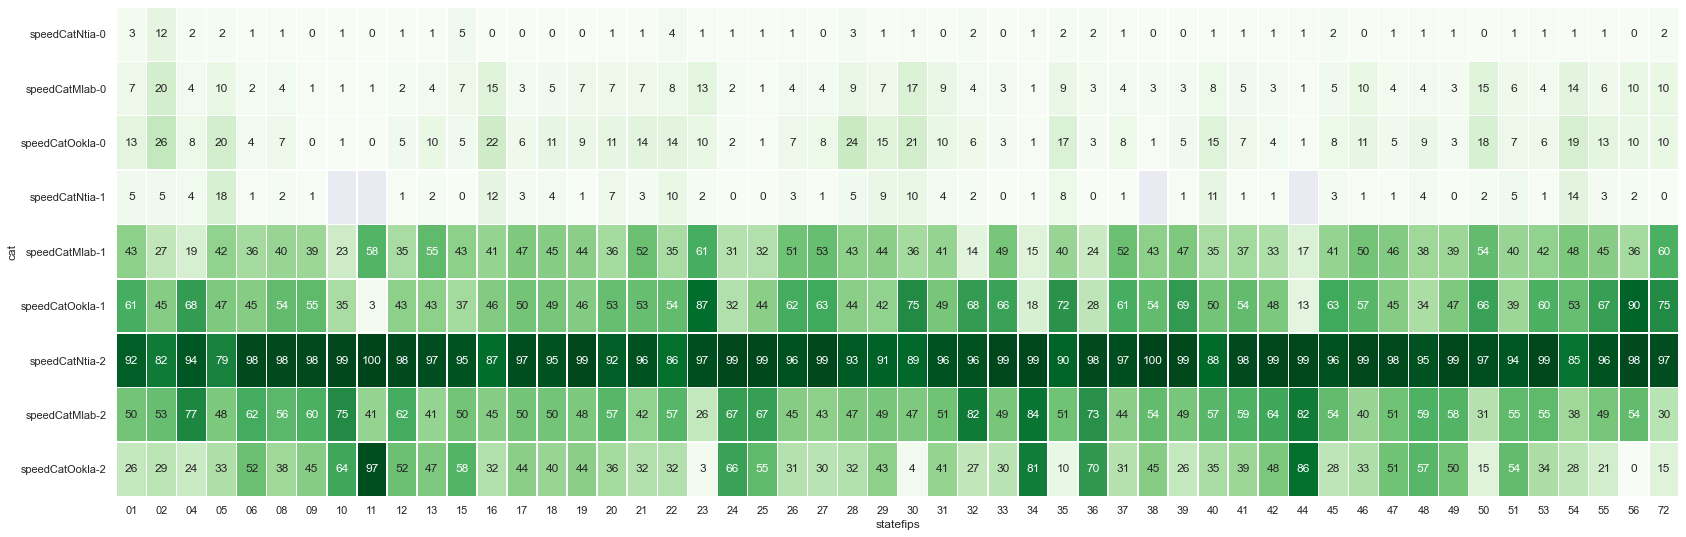

In [170]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(28, 9))
sns.heatmap(df, 
            annot=True, 
            linewidths=.5, ax=ax, 
            fmt='.0f',
#             center=df.loc["speedCatOokla-1", '29'],
           cbar=False,
#             cmap=['red','orange','green'],,
            cmap='Greens', 
            
           )

## Extreme case: State of Wyoming -- speedCat discrepancies/disputes

In [266]:
statefips = '56'
state_speed = all_speed.loc[all_speed['statefips'] == statefips]
data = []
for speed_cat in ['speedCatNtia', 'speedCatMlab', 'speedCatOokla']:
    cbg_per = dict(state_speed[speed_cat].value_counts().sort_index())            
    for cat, per in cbg_per.items():
        if cat == 0: cat = 'Unserved'
        if cat == 1: cat = 'Underserved'
        if cat == 2: cat = 'Good'
        row = [speed_cat, cat, per]
        data.append(row)

df = pd.DataFrame(data, columns=['speed_source', 'Wyoming cbg', 'num_cbgs'])
df = df.pivot('speed_source', 'Wyoming cbg',  'num_cbgs')
df = df.reindex(['speedCatNtia', 'speedCatMlab', 'speedCatOokla'])

<AxesSubplot:xlabel='Wyoming cbg', ylabel='speed_source'>

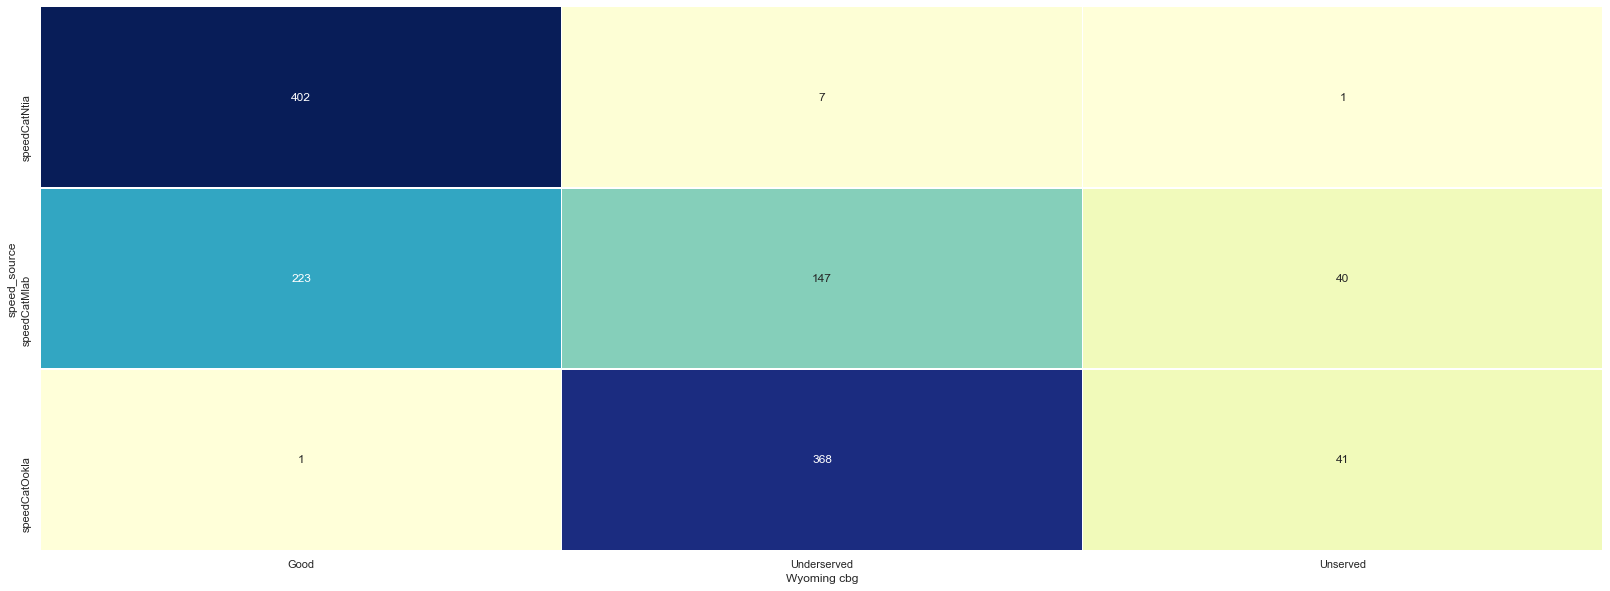

In [267]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(28, 10))
sns.heatmap(df, 
            annot=True, 
            linewidths=.5, ax=ax, 
            cmap="YlGnBu", 
            fmt='.0f',
#             center=df.loc["speedCatOokla-1", '29'],
           cbar=False,
           )

In [143]:
data = []
for speed_cat in ['speedCatNtia', 'speedCatMlab', 'speedCatOokla']:
    cbg_per = dict(state_speed[speed_cat].value_counts(normalize=True).sort_index())            
    for cat, per in cbg_per.items():
        if cat == 0: cat = 'Unserved'
        if cat == 1: cat = 'Underserved'
        if cat == 2: cat = 'Good'
        row = [speed_cat, cat, per]
        data.append(row)

df = pd.DataFrame(data, columns=['source', 'cat', 'percentage'])
# df = df.pivot('speed_source', 'Wyoming cbg',  'num_cbgs')
# df = df.reindex(['speedCatNtia', 'speedCatMlab', 'speedCatOokla'])

sns.catplot(x='source', y='percentage', hue='cat', kind='bar', data=df, palette="Set2")

NameError: name 'state_speed' is not defined

# bossdata29: cbg_29 vs cb29

In [ ]:
# IMPORT 
# cb29 = pd.read_csv('cb29_oz_speedrank.csv')
# cb29['statefips'] = cb29['statefips'].astype(str).str.zfill(STATE_FIPS_LENGTH)
# cb29['GEOID_cbg'] = cb29['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)



In [119]:
cbg_speed = pd.read_csv('all_speed.csv')
cbg_speed['statefips'] = cbg_speed['statefips'].astype(str).str.zfill(STATE_FIPS_LENGTH)
cbg_speed['GEOID_cbg'] = cbg_speed['GEOID_cbg'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)

cbg_speed.shape # (220333, 36)

statefips = '29'
cbg_29 = cbg_speed.loc[cbg_speed['statefips'] == statefips]
cbg_29 = cbg_29.drop(columns=['statefips'])

set(cb29.columns) - set(cbg_29.columns)
# set(cbg_29.columns) - set(cb29.columns) 

set(cb29['GEOID_cbg']) - set(cbg_29['GEOID_cbg']) # set() GOOD!

GEOID_cbg                 object
maxDownloadMbpsMlab      float64
maxUploadMbpsMlab        float64
meanDownloadMbpsMlab     float64
meanUploadMbpsMlab       float64
medDownloadMbpsMlab      float64
medUploadMbpsMlab        float64
minDownloadMbpsMlab      float64
minUploadMbpsMlab        float64
numDeviceDownloadMlab    float64
numDeviceUploadMlab      float64
numTestDownloadMlab      float64
numTestUploadMlab        float64
speedCatMlab             float64
speedSourceMlab           object
maxDownloadMbpsOokla     float64
maxUploadMbpsOokla       float64
meanDownloadMbpsOokla    float64
meanUploadMbpsOokla      float64
medDownloadMbpsOokla     float64
medUploadMbpsOokla       float64
minDownloadMbpsOokla     float64
minUploadMbpsOokla       float64
numDeviceOokla           float64
numTestOokla             float64
speedCatOokla            float64
speedSourceOokla          object
MaxConsumerDown98        float64
MaxConsumerUp98          float64
numISPfiber              float64
numISPothe

<AxesSubplot:xlabel='MISSOURI cbg', ylabel='speed_source'>

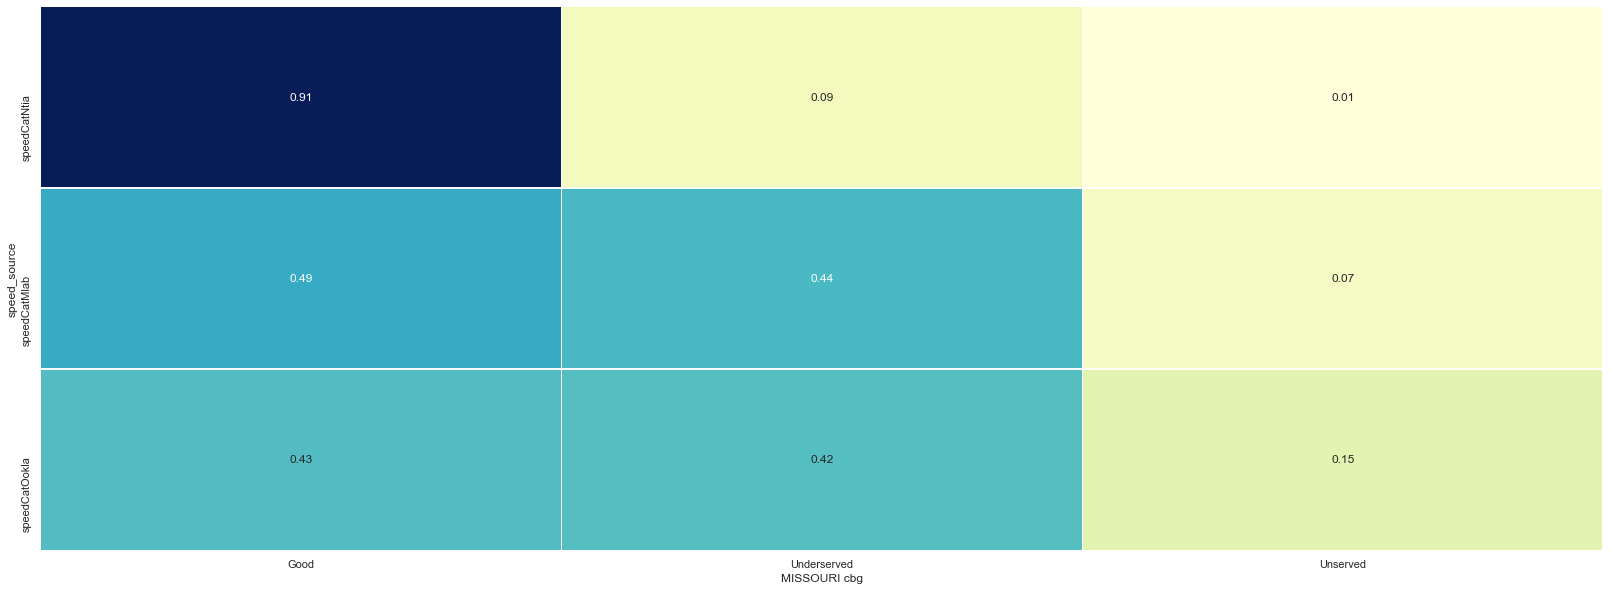

In [144]:
data = []
for speed_cat in ['speedCatNtia', 'speedCatMlab', 'speedCatOokla']:
    cbg_per = dict(cbg_29[speed_cat].value_counts(normalize=True).sort_index())            
    for cat, per in cbg_per.items():
        if cat == 0: cat = 'Unserved'
        if cat == 1: cat = 'Underserved'
        if cat == 2: cat = 'Good'
        row = [speed_cat, cat, per]
        data.append(row)

df = pd.DataFrame(data, columns=['speed_source', 'MISSOURI cbg', 'num_cbgs'])
df = df.pivot('speed_source', 'MISSOURI cbg',  'num_cbgs')
df = df.reindex(['speedCatNtia', 'speedCatMlab', 'speedCatOokla'])

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(28, 10))
sns.heatmap(df, 
            annot=True, 
            linewidths=.5, ax=ax, 
            cmap="YlGnBu", 
            fmt='.2f',
#             center=df.loc["speedCatOokla-1", '29'],
           cbar=False,
           )

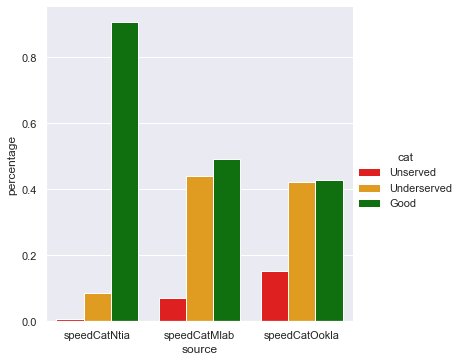

In [146]:
data = []
for speed_cat in ['speedCatNtia', 'speedCatMlab', 'speedCatOokla']:
    cbg_per = dict(cbg_29[speed_cat].value_counts(normalize=True).sort_index())            
    for cat, per in cbg_per.items():
        if cat == 0: cat = 'Unserved'
        if cat == 1: cat = 'Underserved'
        if cat == 2: cat = 'Good'
        row = [speed_cat, cat, per]
        data.append(row)

df = pd.DataFrame(data, columns=['source', 'cat', 'percentage'])
# df = df.pivot('speed_source', 'Wyoming cbg',  'num_cbgs')
# df = df.reindex(['speedCatNtia', 'speedCatMlab', 'speedCatOokla'])

# sns.catplot(x='source', y='percentage', hue='cat', kind='bar', data=df, palette="Set2")
sns.catplot(x='source', y='percentage', hue='cat', kind='bar', data=df, palette=['red','orange','green'])

# Speed funding projection for each cbg_29

In [ ]:
## TODO HERE NOW

### cb29.shape # (343565, 39) # VS cbg_29.shape # (4506, 35)

In [140]:
#### cb29.isnull().sum()

GEOID_cbg                    0
speedSourceNtia              0
speedCatNtia                 0
numISPfiber              36082
numISPother              36082
numISPwireless           36082
num_household                0
MaxConsumerDown98            0
MaxConsumerUp98              0
maxDownloadMbpsMlab       3730
maxDownloadMbpsOokla      2786
maxUploadMbpsMlab         3730
maxUploadMbpsOokla        2786
meanDownloadMbpsMlab      3730
meanDownloadMbpsOokla     2786
meanUploadMbpsMlab        3730
meanUploadMbpsOokla       2786
medDownloadMbpsMlab       3730
medDownloadMbpsOokla      2786
medUploadMbpsMlab         3730
medUploadMbpsOokla        2786
minDownloadMbpsMlab       3730
minDownloadMbpsOokla      2786
minUploadMbpsMlab         3730
minUploadMbpsOokla        2786
numDeviceDownloadMlab     3730
numDeviceOokla            2786
numDeviceUploadMlab       3730
numTestDownloadMlab       3730
numTestOokla              2786
numTestUploadMlab         3730
speedCatMlab                 0
speedCat

#### cb29.isnull().sum()